<a href="https://colab.research.google.com/github/bkokalari/Doctoranytime-User-reviews-moderation-with-deep-learning/blob/main/English/Undersampling_simple_transformers_roberta_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple transformers and Roberta

In [1]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 2.6MB/s 
     |████████████████████████████████| 7.4MB 7.0MB/s 
     |████████████████████████████████| 1.7MB 30.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 1.3MB 44.7MB/s 
     |████████████████████████████████| 317kB 44.8MB/s 
     |████████████████████████████████| 2.9MB 41.4MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 112kB 39.3MB/s 
     |████████████████████████████████| 163kB 41.3MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 6.7MB 38.3MB/s 
     |████████████████████████████████| 133kB 39.3MB/s 
     |████████████████████████████████| 4.4MB 41.9MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 122kB 41.5MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 
     |████████████████████████████████| 1.1MB 37.3MB/s

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import torch
import sklearn
import wandb

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
import os
os.chdir('/content/drive/My Drive')

## Process data

In [5]:
path_root = "/content/drive/My Drive/"
revs_preprocessed = pd.read_csv(r'augmented_data_english.csv') 
revs_preprocessed = revs_preprocessed.dropna()
revs_preprocessed['TranslatedReview'] = revs_preprocessed['TranslatedReview'].astype(str)
revs_preprocessed.sample(5)


,TranslatedReview,Approved
112649,"Consistent, serious, polite, he dealt with my ...",1
49300,Very good and experienced! I was not in pain a...,1
30214,VERY GOOD DOCTOR,1
9653,"Attentive, polite and explanatory as always.",1
51090,"Serious, trained, nice place",1


In [6]:
revs_preprocessed.Approved.value_counts()

1                                      123099
0                                        8472
 dkgn                                       1
 Do not look for it better this was         1
 What else should one write?                1
)                                           1
Name: Approved, dtype: int64

In [7]:
revs = revs_preprocessed

revs0 = revs[(revs.Approved == "0")]
revs1 = revs[(revs.Approved == "1")]
revs = pd.concat([revs0, revs1], ignore_index=True).sample(frac=1)
revs.Approved = revs.Approved.astype(int)

revs.Approved.value_counts()

1    123099
0      8472
Name: Approved, dtype: int64

## Split Dataset

In [8]:
from sklearn.preprocessing import OneHotEncoder

# splitting in train-validation-test sets in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:
# sss: stratified shuffle split

# We will use this object to split the raw dataset in Train - Test in a stratified manner.

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [10]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25,
            train_size=None)

In [11]:
reviews = revs.TranslatedReview
approval = revs.Approved

In [12]:
# splitting in train-val and test

X_train_val, X_test, y_train_val, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(reviews, approval):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = reviews.iloc[train_index], reviews.iloc[test_index]
    y_train_val, y_test = approval.iloc[train_index], approval.iloc[test_index]

TRAIN-VAL: [ 88121  98423 113322   8365  88743 124976 106979  59777   6472  53948] TEST: [102149 103053   9157  44058 124310   1714 123890  72520  27278   2982]
TRAIN-VAL: [ 51092 109617  75894    702  47139  18641  71265   5144 122359 112507] TEST: [ 78905 101448  24462  29899  39807  85651 122219  14634  97931  58029]
TRAIN-VAL: [124848  65931 123459  17334  40621 118688  22006  64706 100906   7001] TEST: [ 86062 130383  73759  65983  93510   2624  73900  89261  36602  19476]
TRAIN-VAL: [  1918 107215  47670  14242  81565 107710  94110 114316  52626 124143] TEST: [126337  45133   6946 127411  71011  34981  17370  68359 131162  49989]
TRAIN-VAL: [71819 12292 31454 48761 55488 71564 55344 34365 15535 70098] TEST: [ 72809  65807   4549 128337  42704   6160  95296  34616 129890  52350]


In [13]:
X_train_val.head()

116707    He is distinguished by perfect composition and...
116737    One of the kindest doctors I have ever met. He...
67092                         Excellent doctor and friendly
69828     An experienced doctor who inspires confidence,...
19988     Very good man and scientist made a program bas...
Name: TranslatedReview, dtype: object

In [14]:
X_train_val.shape, X_train_val.dropna().shape

((105256,), (105256,))

In [15]:
y_train_val.shape, y_train_val.dropna().shape

((105256,), (105256,))

In [16]:
# We reset the indexes for bot the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [17]:
# splitting the train-val dataset into train and validation dataset

X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

TRAIN: [ 79931  50094 102010   3897  33430   5540  11302  55860  19938   3531] VALID: [ 72809  65807   4549 128337  42704   6160  95296  34616 129890  52350]
TRAIN: [15799 60485 75068 10970 54369 43876 33645 41324 51379 95514] VALID: [ 72809  65807   4549 128337  42704   6160  95296  34616 129890  52350]
TRAIN: [103513 101143  35584  20467  58608    339  95742  35990  60043  12247] VALID: [ 72809  65807   4549 128337  42704   6160  95296  34616 129890  52350]
TRAIN: [ 61636  85516  63844 104801 103935  23320  60396   7149  80161  60598] VALID: [ 72809  65807   4549 128337  42704   6160  95296  34616 129890  52350]
TRAIN: [ 92765  55498 100902  65633  93672  14684 101333  11320  41091 102372] VALID: [ 72809  65807   4549 128337  42704   6160  95296  34616 129890  52350]


In [18]:
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train_val shape: (105256,)
y_train_val shape: (105256,)

X_train shape: (78942,)
y_train shape: (78942,)

X_val shape: (26314,)
y_val shape: (26314,)

X_test shape: (26315,)
y_test shape: (26315,)


#Undersampling




In [19]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.Approved==0]
approved = X[X.Approved==1]

# upsample minority
appr_downsampled = resample(approved,
                          replace=True, # sample with replacement
                          n_samples=25000, # match number in majority class
                          random_state=27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_approved, appr_downsampled])

# check new class counts
print(downsampled.Approved.value_counts())
downsampled = downsampled.sample(frac=1) #shuffle

1    25000
0     5084
Name: Approved, dtype: int64


In [20]:
 import numpy as np
r_train, r_validate, r_test = np.split(downsampled.sample(frac=1), [int(.6*len(downsampled)), int(.8*len(downsampled))])

In [21]:
r_train.Approved.value_counts()

1    14995
0     3055
Name: Approved, dtype: int64

## Initiliazations

In [22]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. The first column is the text with type str, and the second column is the label with type int.
train_data = r_train
train_df = pd.DataFrame(train_data)

eval_data = r_validate
eval_df = pd.DataFrame(eval_data)

model_path = path_root+"saved_models/savedModel_Robertun1"



##Model

### 1 epoch


In [23]:
# Create a TransformerModel
train_args={
    'overwrite_output_dir': True
}

# Create a ClassificationModel
model1un = ClassificationModel('roberta', 'roberta-base',args=train_args)

# Train the model
model1un.train_model(train_df)



INFO:filelock:Lock 140130458310696 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690.lock


INFO:filelock:Lock 140130458310696 released on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690.lock


INFO:filelock:Lock 140127824967608 acquired on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock


INFO:filelock:Lock 140127824967608 released on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

INFO:filelock:Lock 140127824968616 released on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


INFO:filelock:Lock 140127824968616 acquired on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


INFO:filelock:Lock 140127824968616 released on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:353: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(2257, 0.24289295752496676)

In [24]:
torch.save(model1un, model_path )

### 2 epochs

In [25]:
# Create a TransformerModel
train_args2={
    'overwrite_output_dir': True,
    'num_train_epochs': 2
}

# Create a ClassificationModel
model2un= ClassificationModel('roberta', 'roberta-base',args=train_args2)

# Train the model
model2un.train_model(train_df)



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(4514, 0.20727487625042534)

In [27]:
two_epochs_model_path = path_root+"saved_models/savedModel_Robertun2"
torch.save(model2un, two_epochs_model_path )

In [28]:
model1un = torch.load(model_path)
from simpletransformers.classification import ClassificationModel
result, model_outputs, wrong_predictions = model1un.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8201863264141167, 'tp': 4859, 'tn': 854, 'fp': 203, 'fn': 101, 'acc': 0.9494764832973243, 'eval_loss': 0.19862042129804117}


In [29]:
model2un = torch.load(two_epochs_model_path)
result2, model_outputs2, wrong_predictions2 = model2un.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:851: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8317752203965908, 'tp': 4857, 'tn': 874, 'fp': 183, 'fn': 103, 'acc': 0.9524680073126143, 'eval_loss': 0.2204822089979462}


# Testing the models

##Random manual testing

In [30]:
predictions, raw_outputs = model1un.predict(['you are a fucking asshole ', 'the doctor was really good',' dsf', ' dfjdnf@fdfg.gr 29954954', 'he charged me 10000 euros for bullshit' ])
predictions

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


array([0, 1, 0, 0, 0])

In [31]:
r_test.head()

,TranslatedReview,Approved
52082,"Very polite and professional, I would definite...",1
4376,Treatment given to me by a doctor helped me im...,1
66775,really great,1
103836,very well,1
203,The best orthopedist I have visited.,1


In [32]:
test_data = r_test
test_df = pd.DataFrame(test_data)

In [33]:
r_test.Approved.value_counts()

1    5045
0     972
Name: Approved, dtype: int64

In [34]:
r_test.TranslatedReview.values

array(['Very polite and professional, I would definitely go again.',
       'Treatment given to me by a doctor helped me immediately. Thank you very much!',
       'really great', ...,
       'Exact at the time of the appointment. To the point the diagnosis and treatment are drastic and immediate. Recommended with closed eyes.',
       'Everything is perfect. He explained to me in detail what was about my case. I was very satisfied and I will prefer it again if needed in the future.',
       'Very good doctor and pleasant man. Although I was visiting Mr. Chountis for the first time, I immediately felt comfortable and he helped me get rid of the anxiety I had. He immediately diagnosed the problem, prescribed me the appropriate treatment and for this I highly recommend it.'],
      dtype=object)

##Test dataset

In [35]:
y_test = r_test.TranslatedReview.values

predictions2,raw2 = model1un.predict(y_test)


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [36]:
predictions2epochs, raw2epochs = model2un.predict(y_test)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [37]:
y_values = r_test.Approved.values

##Results 1 epoch

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [39]:
conf_mat = confusion_matrix(y_true=y_values,
                            y_pred=predictions2)
conf_mat

array([[ 805,  167],
       [ 106, 4939]])

In [40]:
import matplotlib.pyplot as plt

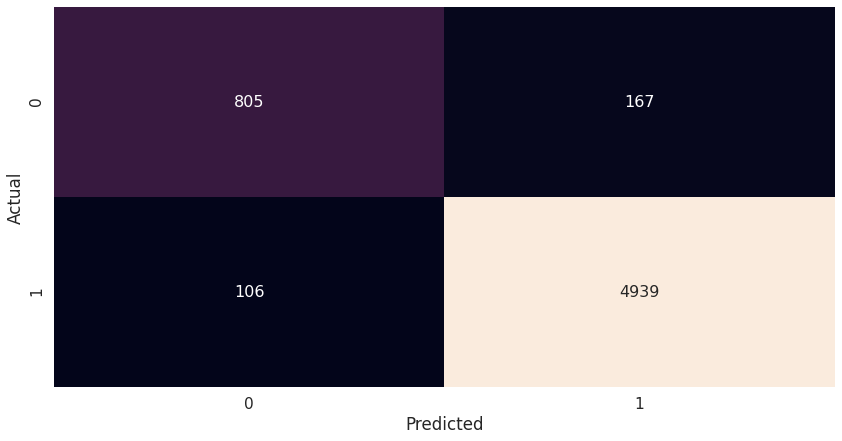

In [41]:


array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [42]:
print(classification_report(y_true=y_values,
                            y_pred=predictions2))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       972
           1       0.97      0.98      0.97      5045

    accuracy                           0.95      6017
   macro avg       0.93      0.90      0.91      6017
weighted avg       0.95      0.95      0.95      6017



##Results 2 epochs

In [43]:
conf_mat2 = confusion_matrix(y_true=y_values,
                            y_pred=predictions2epochs)
conf_mat2

array([[ 836,  136],
       [ 103, 4942]])

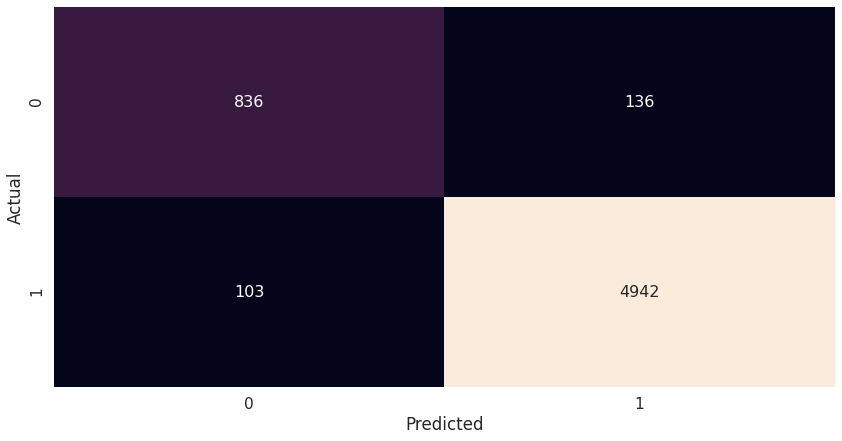

In [44]:


array_final = conf_mat2
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [45]:

print(classification_report(y_true=y_values,
                            y_pred=predictions2epochs))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       972
           1       0.97      0.98      0.98      5045

    accuracy                           0.96      6017
   macro avg       0.93      0.92      0.93      6017
weighted avg       0.96      0.96      0.96      6017



# Production use

## Load saved model

In [46]:
prod_model = torch.load(two_epochs_model_path)

In [47]:
greek_text_1 = "Ο γιατρός ήταν πολύ καλός! Με βοήθησε με το πρόβλημά μου. Τον συνιστώ"
greek_text_0 = "Απαράδεκτος. με χρέωσε 150 ευρώ χωρίς απόδειξη και δεν ασχολήθηκε καθόλου"

## Translate greek text

In [49]:
from textblob import TextBlob

blob_obj_1 = TextBlob(greek_text_1)
translated_1 = str(blob_obj_1.translate(to="en"))

translated_1

'The doctor was very good! He helped me with my problem. I recommend it'

In [50]:
blob_obj_0 = TextBlob(greek_text_0)
translated_0 = str(blob_obj_0.translate(to="en"))
translated_0

'Inadmissible. he charged me 150 euros without a receipt and did not bother at all'

In [51]:
prediction_1, raw_output_1 = prod_model.predict([translated_1])
prediction_1

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


array([1])

## Predict

In [52]:
prediction_0, raw_output_0 = prod_model.predict([translated_0])
prediction_0

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


array([0])

In [53]:
!pip install -U textblob

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
